In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import numpy as np

from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

In [ ]:
# p values IF2
pvalues_path=r"p_values_IF2.tsv"
pvalues=pd.read_csv(pvalues_path, sep='\t', index_col=0)

# correlations IF2
correlations_path=r"correlations_IF2.tsv"
correlations=pd.read_csv(correlations_path, sep='\t', index_col=0)


In [2]:
def cluster_heatmap(df, kmeans):
    
    #giving cluster index to columns
    cluster_labels=kmeans.labels_

    #data frame with cells and clusters
    clustered_cells=pd.DataFrame({"Cell": df.columns, "Cluster": cluster_labels})

    #sorting by cluster
    sorted_cells=clustered_cells.sort_values("Cluster")["Cell"].values
    sorted_df=df[sorted_cells]

    #adding cluster to column names
    new_column_names=[]

    cluster_mapping=clustered_cells.set_index("Cell").loc[sorted_cells]["Cluster"]

    for col in sorted_cells:
        cluster=cluster_mapping[col]
        new_column_names.append(f"{col} (Cluster {cluster})") 

    sorted_df.columns=new_column_names


    #heatmap for average value in clusters
    df_avg=df.T
    df_avg["Cluster"]=cluster_labels #adding column with clusters
    cluster_means=df_avg.groupby("Cluster").mean() #average value for every cluster
    cluster_counts=df_avg["Cluster"].value_counts().sort_index() #counting samples in every cluster

    #changing column names to cluster and their samples count
    cluster_labels_with_counts=[f"Cluster {i} ({count} elements)" for i, count in enumerate(cluster_counts)]
    cluster_means=cluster_means.T
    cluster_means.columns=cluster_labels_with_counts

    return sorted_df, cluster_means


In [3]:
def cluster(df, title):
    df_t=df.T #transpose

    inertias=[]
    sil_scores=[]

    fig, axes=plt.subplots(9, 3, figsize=(40, 90))

    for n_clusters in range(2,11):
        kmeans=KMeans(n_clusters=n_clusters) #clustering
        cluster_labels=kmeans.fit_predict(df_t)

        silhouette_vals=silhouette_samples(df_t, cluster_labels) #scores for each cluster
        silhouette_avg=silhouette_score(df_t, cluster_labels) #average score

        inertias.append(kmeans.inertia_) #saving inertias for elbow method
        sil_scores.append(silhouette_avg) #saving average silhouette scores for the general plot

        #creating the silhouette plot
        ax1=axes[n_clusters-2, 0] # first column of the plot
        y_lower=10


        for j in range(n_clusters):
        
            cluster_silhouette_vals=silhouette_vals[cluster_labels==j] #silhouette values for the current cluster
            cluster_silhouette_vals.sort()

            size_cluster_j=cluster_silhouette_vals.shape[0] #size of one cluster part of the silhouette plot
            y_upper=y_lower+size_cluster_j

            #plot silhouette values for the cluster
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals)
            ax1.text(-0.05, y_lower+0.5*size_cluster_j, str(j))
            
            #update y_lower for the next plot
            y_lower=y_upper+10

        #plot settings
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--") #red line for average silhouette score
        ax1.set_title(f"Silhouette plot for {title} (n={n_clusters})")
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.set_xlim([-0.1, 1])
        ax1.set_yticks([])


        #creating gradient heatmap
        clstr_heatmap, clstr_avg_heatmap=cluster_heatmap(df, kmeans)
        ax2=axes[n_clusters-2, 1] #second column of the plot
        sns.heatmap(clstr_heatmap, annot=True, cbar_kws={'label': 'Correlation'}, fmt=".1f", ax=ax2, center=0, cmap='seismic')
        ax2.set_title(f"Clustered cells by correlation in {title} with {n_clusters} clusters")
        ax2.set_xlabel("Cells")
        ax2.set_ylabel("Signatures")


        ax3=axes[n_clusters-2, 2] #third column of the plot
        sns.heatmap(clstr_avg_heatmap, annot=True, cbar_kws={"label": "Mean Value"}, fmt=".2f", ax=ax3, center=0, cmap='seismic')
        ax3.set_title(f"Mean value for clusters in {title} with {n_clusters} clusters")
        ax3.set_xlabel("Cluster")
        ax3.set_ylabel("Signatures")
    
    plt.tight_layout()
    plt.show()


    #elbow plot
    plt.plot(range(2,11), inertias, marker='o', label='Inertias')
    plt.title(f'Inertias in {title} for the elbow method')
    plt.xlabel('Number of clusters')
    plt.legend()
    plt.show()

    #average silhouette score plot
    plt.plot(range(2,11), sil_scores, marker='o', label='Silhouette Score', color='Red')
    plt.title(f'Average silhouette score plot in {title}')
    plt.xlabel('Number of clusters')
    plt.legend()
    plt.show()

In [3]:
def filter(pvals, corrs):
    numeric_columns=pvals.select_dtypes(include=["number"]) #only numeric columns
    columns_to_drop=numeric_columns.columns[(numeric_columns>0.05).all()] #columns to drop
    corrs=corrs.drop(columns=columns_to_drop)
    return corrs

In [ ]:
#filtering data
correlations=filter(pvalues, correlations)

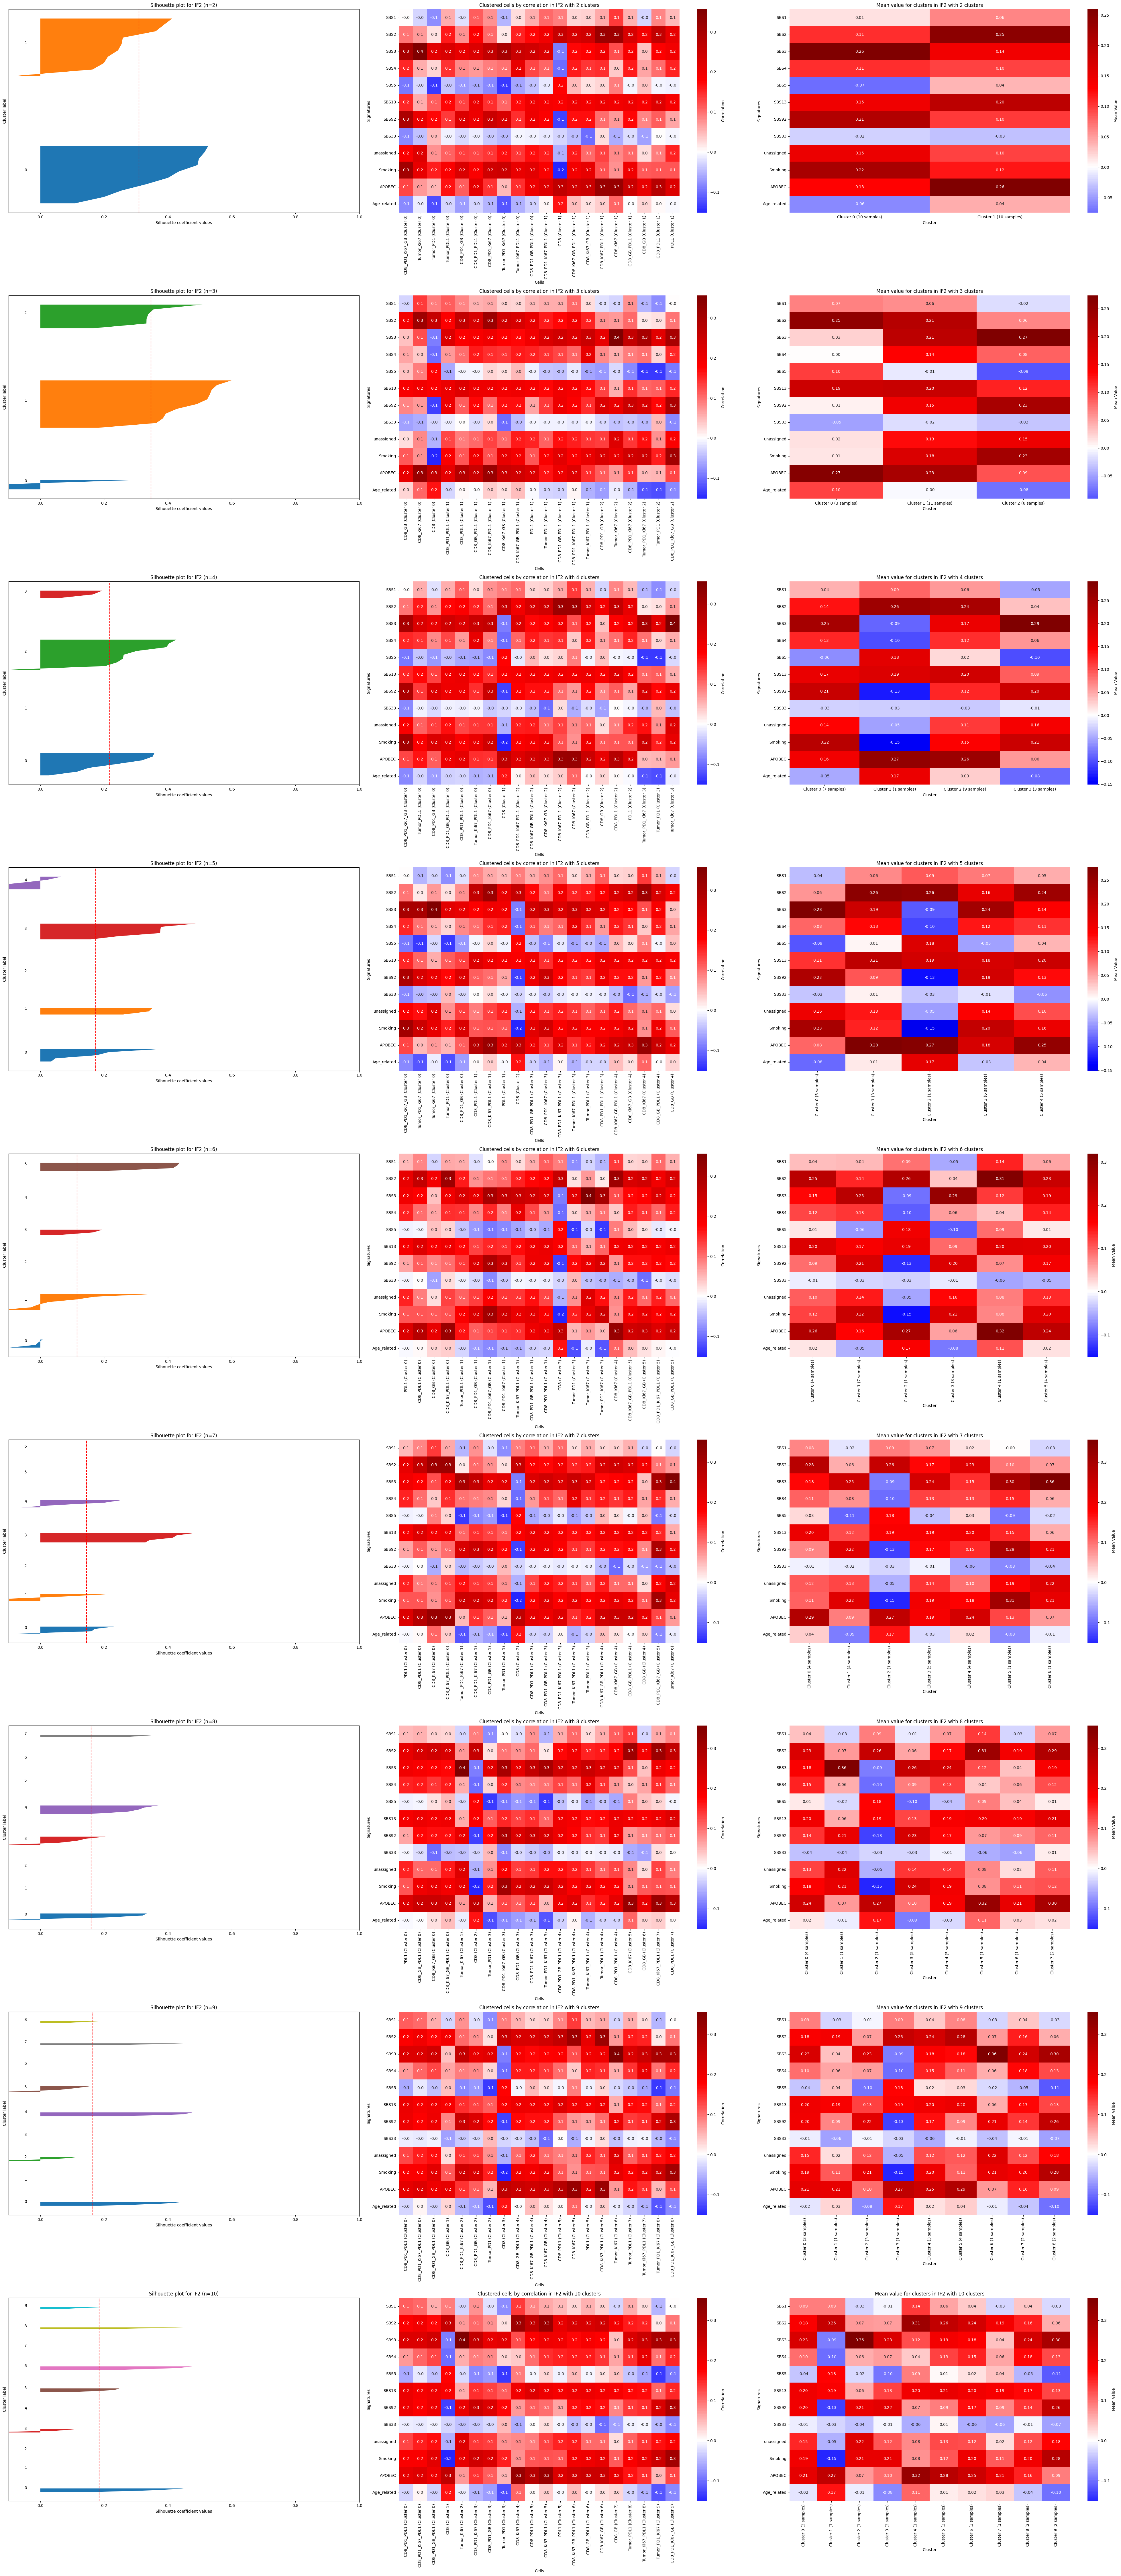

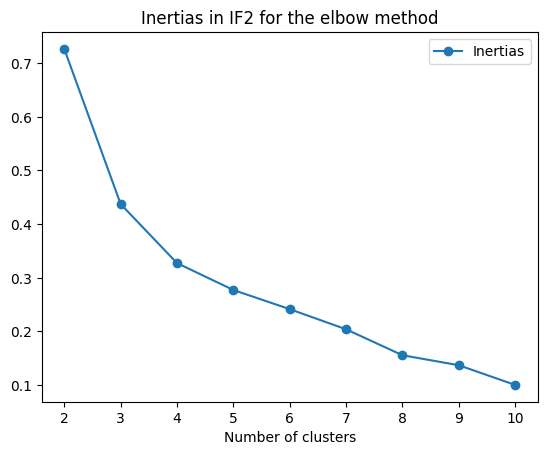

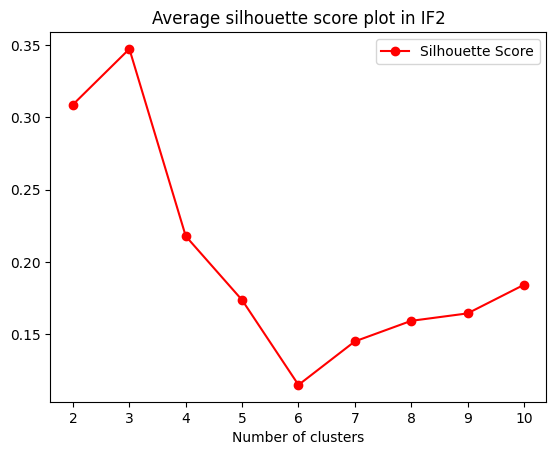

In [17]:
#silhouette plots, clustering, plot for avg in clusters, for k=2...10
#inertias plot for elbow method and average silhouette score plot
cluster(correlations, "IF2")